In [1]:
%matplotlib inline

In [2]:
import os

import mne
import numpy as np


# Preprocessing
The steps in EEG preprocessing:

* Highpass filter
* Lowpass filter
* Artefact rejection
    * Ocular artifacts (EOG)
    * Heartbeat artifacts (ECG)
    * Power line noise
    * Methods:
        * Thresholding
        * ICA
* (Rereference)
* Epoching
* Evokeds (i.e. averaging)


In [3]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')

In [4]:
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
# preload=True loads the information into memory. You might not always want that

Opening raw data file C:\Users\Sara\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [5]:
raw.pick_types(meg=False, eeg=True, stim=True)

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

In [7]:
# filter your data
# High-pass and low-pass filtering
raw.info

# if you were to filter your data
# raw_filtered = raw.copy.filter(l_freq=0.1, h_freq=40)


<Info | 14 non-empty values
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 STIM, 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 68
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

Default filtering for the sample data is:
* highpass: 0.1 Hz
* lowpass: 40 Hz

You can see this by:
print(raw.info)

It is better to filter in two step

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


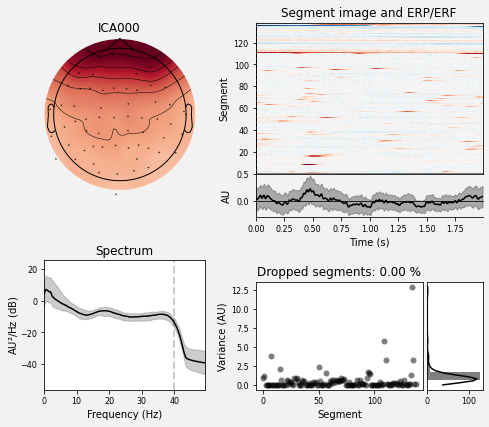

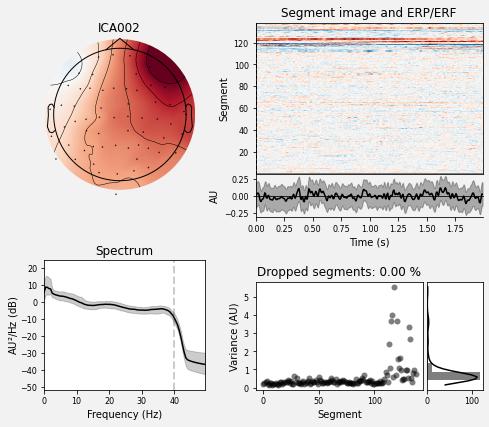

In [13]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)

How to chose components: Give me components until you explain 95% of the variance (maybe you can write n_components=0.95)

Then you find all the components that you want to exclude

https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#tut-artifact-ica

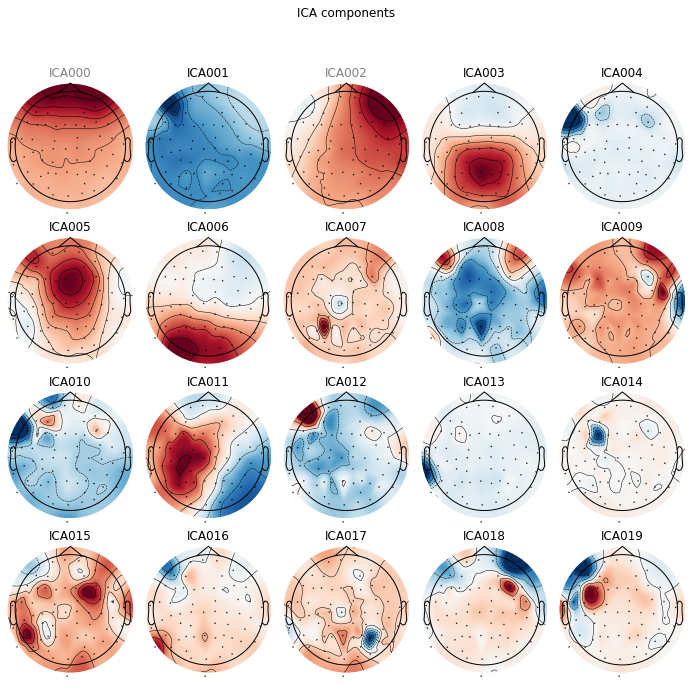

In [14]:
ica.plot_components();
# first component explains most of the data, and so on....

Creating RawArray with float64 data, n_channels=20, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


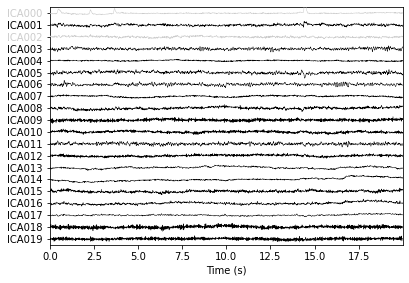

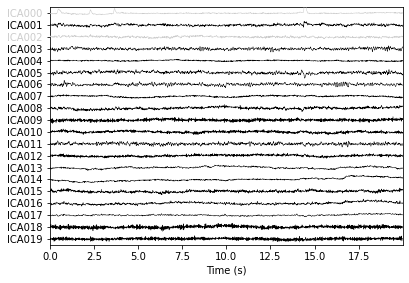

In [10]:
#Plotting the time series of the ICA.
ica.plot_sources(raw, show_scrollbars=False)

In [ ]:
# components two exclude
ica.exclude = [0, 2]  # this is two of the components - we have identified these as artefacts
ica.plot_properties(raw, picks=ica.exclude);

In [16]:
orig_raw = raw.copy()
# raw.load_data() # this line is only needed, if you haven't done the preload=True when reading in raw
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

There are many options with ICA, see
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
for a tutorial on ICA in MNE-python.

In [22]:
# the stimulus channel on the Electra vector view is: STI 014
events = mne.find_events(raw, stim_channel='STI 014')

319 events found
Event IDs: [ 1  2  3  4  5 32]


array([[6994,    0,    2],
       [7086,    0,    3],
       [7192,    0,    1],
       [7304,    0,    4],
       [7413,    0,    2]], dtype=int64)

you can find event name by print(raw.info)

There are 6 events (thus, 6 stim_channels) and then 014, which is a summation (according to tutorial)

In [23]:
events[:5]
# with sample number in the first column and integer event ID in the last column; the middle column is usually ignored.

array([[6994,    0,    2],
       [7086,    0,    3],
       [7192,    0,    1],
       [7304,    0,    4],
       [7413,    0,    2]], dtype=int64)

In [24]:
event_dict = {'auditory/left': 1,
              'auditory/right': 2,
              'visual/left': 3,
              'visual/right': 4,
              'smiley': 5, 
              'buttonpress': 32
              }

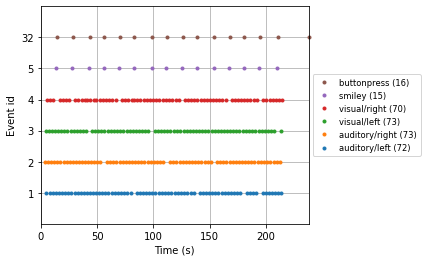

In [25]:
# plotting the events
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

In [26]:
reject_criteria = dict(eeg=150e-6)  # 150 µV
# we’ll reject any epoch where peak-to-peak signal amplitude is beyond reasonable limits for that channel type.
# This is done with a rejection dictionary;


In [27]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']


In [28]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)

# tmin is when you start the epoch and tmax is when you end it
epochs = mne.Epochs(raw, events, event_dict, tmin=-.2, tmax=0.5, picks=picks,
                    baseline=None, reject=reject_criteria, preload=True)


Not setting metadata
Not setting metadata
319 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 008']
1 bad epochs dropped


# Comparing evokeds

To visually comparing different evoked objects it is a good idea to calculate
 a _difference  wave_, i.e. one condition minus the other condition. In
 MNE-python ```mne.combine_evokeds``` can do that.

In [33]:
# To avoid biasing our signals to the left or right, we’ll use equalize_event_counts first to randomly sample epochs from each condition to match the number of epochs present in the condition with the fewest good epochs.
epochs.equalize_event_counts(conds_we_care_about)  
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']

Dropped 8 epochs: 0, 1, 14, 16, 18, 35, 101, 231


In [35]:
# Change to your evokeds
difference_wave = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])


See also:
https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html